In [1]:
# magic command to reload modules
%load_ext autoreload
%autoreload 2

In [2]:
# append sys.path
import sys
sys.path.append('../src')

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm

In [3]:
import matplotlib as mpl
# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = True
mpl.rcParams["axes.spines.top"] = True

# remove all edges
mpl.rcParams["axes.edgecolor"] = "k"
mpl.rcParams['axes.linewidth'] = 2

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
mpl.rc('font', **font)
cmap = ['tab:blue', 'tab:red', 'tab:orange', 'tab:purple', 'tab:green']

In [4]:
!pwd

/Users/admin/Library/CloudStorage/GoogleDrive-wenjhe@ethz.ch/My Drive/02. Master_NSC/02. 2023FS/NSC_Thesis/codes/notebook


## prior plot

In [5]:
import ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
from simulator.DM_model import DM_model
from dataset.seqC_generator import seqC_generator
from dataset.model_sim_store_pR import get_boxUni_prior
from analysis.plot_sim_results import plot_parameters
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [6]:
# generate input sequence
seqC = seqC_generator().generate(
    MS_list=[0.4],
    sample_size=1,
    single_dur=11
)
seqC.shape

(1, 15)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


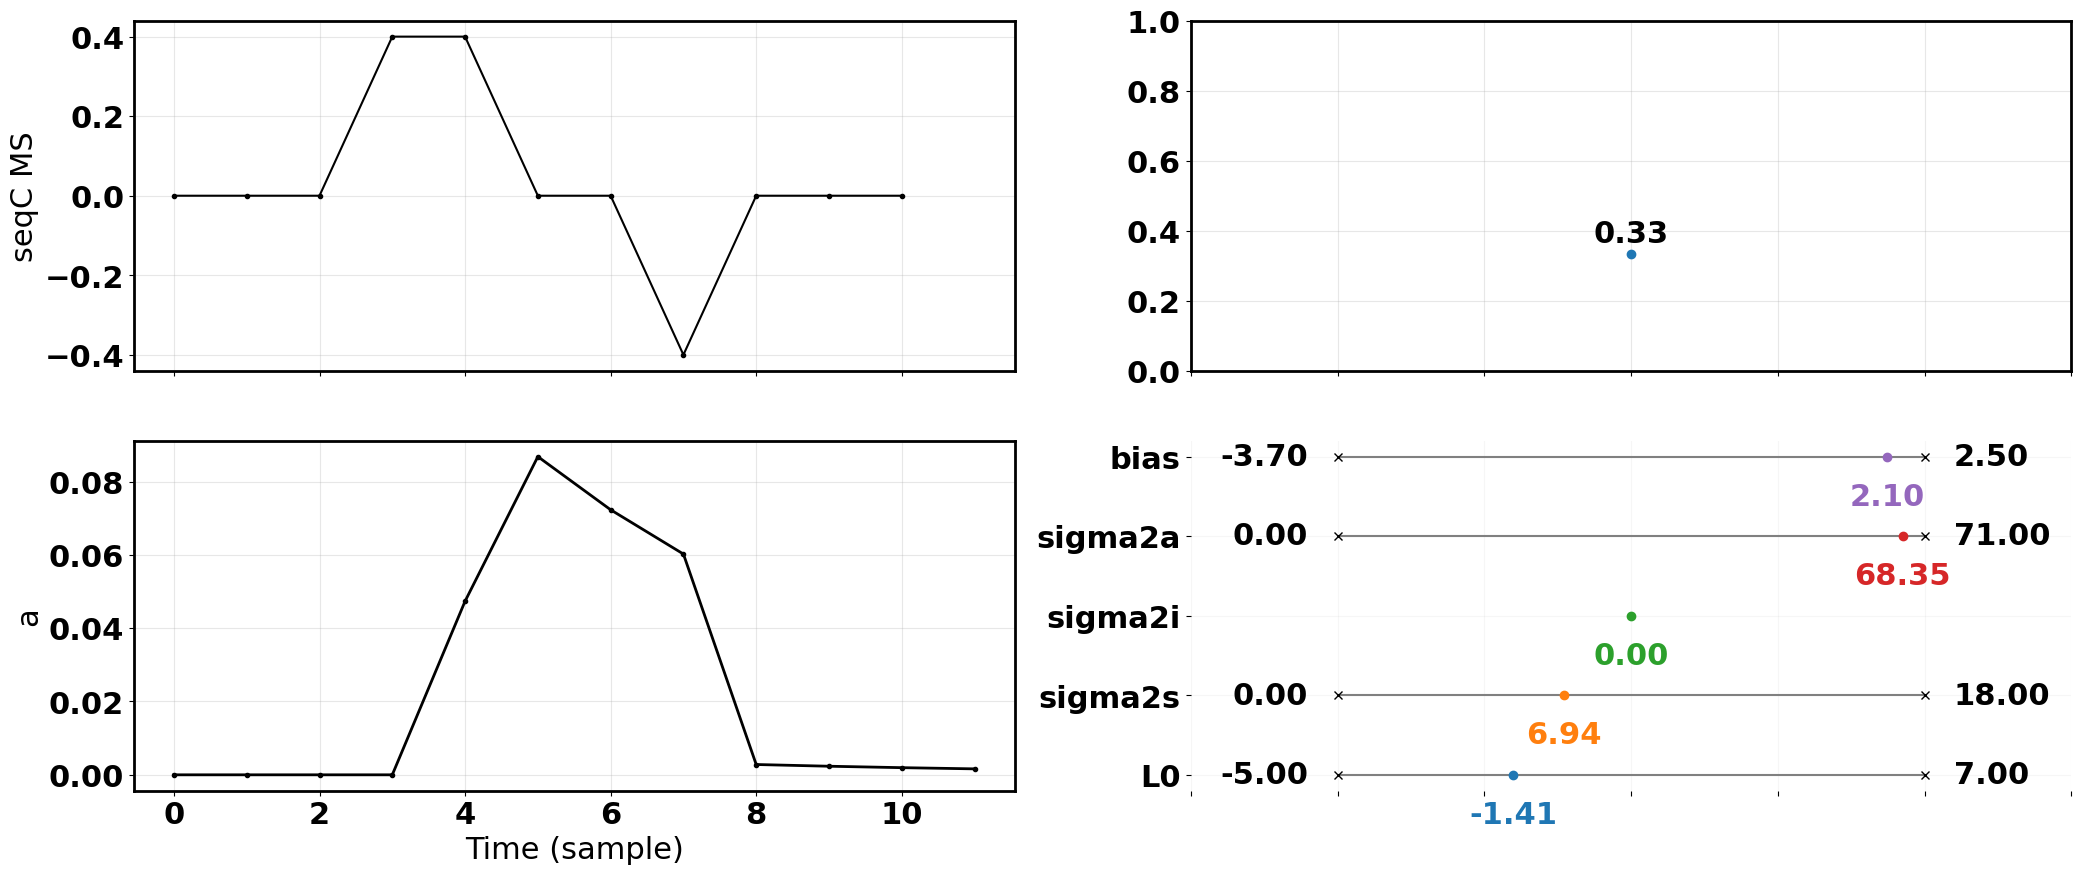

In [7]:
# generate prior parameters
model_name = 'B-G-L0S-O-N-'
prior_min = [-3.7,   0, 0,  0, -5]
prior_max = [ 2.5,  71, 0, 18,  7]
# prior_min = [-3.7,   0, 0,  0, -1]
# prior_max = [ 2.5,  71, 0, 18,  1]
prior = get_boxUni_prior(prior_min, prior_max)
params = prior.sample((1,))[0].tolist()
    
def plot_seqC_a_prior(model_name, prior_min, prior_max, params):
    
    model = DM_model(params=params, modelName=model_name)
    a, probR = model.simulate(seqC)

    fig, axs = plt.subplots(2, 2, sharex='col', figsize=(25, 10))

    # plot input sequence
    ax = axs[0,0]
    ax.clear()
    ax.plot(seqC[0], '.-k')
    ax.grid(alpha=0.3)
    ax.set_ylabel('seqC MS')

    # plot a mean trace
    ax = axs[1,0]
    ax = model.plot_a_mean_trace(ax, a, color='k')
    
    # plot probR
    ax = axs[0,1]
    ax.clear()
    ax.plot(0, probR, 'o')
    if probR<0.5:
        ax.text(0, probR+0.1, f'{probR:.2f}', ha='center', va='top', color='k')
    else:
        ax.text(0, probR-0.1, f'{probR:.2f}', ha='center', va='bottom', color='k')
    ax.grid(alpha=0.3)
    ax.set_xlim(-1,1)
    ax.set_ylim(0,1)

    # plot parameter values
    ax = axs[1,1]
    plot_parameters(ax, params, prior_min, prior_max)

plot_seqC_a_prior(model_name, prior_min, prior_max, params)

## build interface

In [60]:
# generate input sequence
seqC = seqC_generator().generate(
    MS_list=[0.4],
    sample_size=1,
    single_dur=11
)
model_name = 'B-G-L0S-O-N-'
prior_min = [-3.7,   0, 0,  0, -5]
prior_max = [ 2.5,  71, 0, 18,  7]

prior_min = [-2.5,   0, 0,  0, -2.5]
prior_max = [ 2.5,  71, 0, 18,  1.5]
# prior_min = [-2.5,   0, 0,  0, -1]
# prior_max = [ 2.5,  30, 0, 18,  1]

prior = get_boxUni_prior(prior_min, prior_max)
params = prior.sample((1,))[0]

bias_slider = widgets.FloatSlider(value=0, min=prior_min[0], max=prior_max[0], step=0.1, description='bias:')
sigma2a_slider = widgets.FloatSlider(value=0, min=prior_min[1], max=prior_max[1], step=0.1, description='sigma2a:')
sigma2s_slider = widgets.FloatSlider(value=0, min=prior_min[3], max=prior_max[3], step=0.1, description='sigma2s:')
L0_slider = widgets.FloatSlider(value=0, min=prior_min[4], max=prior_max[4], step=0.1, description='L0:')

def update_plot(bias, sigma2a, sigma2s, L0):
    plot_seqC_a_prior(model_name=model_name, prior_min=prior_min, prior_max=prior_max, params=[bias, sigma2a, 0, sigma2s, L0])

interactive_plot = widgets.interactive(update_plot, bias=bias_slider, sigma2a=sigma2a_slider, sigma2s=sigma2s_slider, L0=L0_slider)
display(interactive_plot)


interactive(children=(FloatSlider(value=0.0, description='bias:', max=2.5, min=-2.5), FloatSlider(value=0.0, d…

# check the probR with prior range (-5,7)

## generate a movie

In [58]:
seqC = seqC_generator().generate(
    MS_list=[0.4],
    sample_size=1,
    single_dur=11
)

# generate prior parameters
model_name = 'B-G-L0S-O-N-'
prior_min = [-3.7,   0, 0,  0, -5]
prior_max = [ 2.5,  71, 0, 18,  7]

prior_min = [-3.7,   0, 0,  0, -2.5]
prior_max = [ 2.5,  71, 0, 18,  1.5]

prior_min = [-2.5,   0, 0,  0, -2.5]
prior_max = [ 2.5,  71, 0, 18,  1.5]

prior_min = [-2.5,   0, 0,  0, -2.5]
prior_max = [ 2.5,  20, 0, 18,  1.5]

prior_step = [0.2, 1, 0, 1, 0.25]

params_collection = []
probRs_collection = []
a_collection = []

# for p_bias in tqdm(np.arange(prior_min[0], prior_max[0], prior_step[0])):
for p_bias in [0.5]:    
    # for p_sigma2a in np.arange(prior_min[1], prior_max[1], prior_step[1]):
    for p_sigma2a in [0.1]:
        for p_sigma2s in np.arange(prior_min[3], prior_max[3], prior_step[3]):
        # for p_sigma2s in [2]:
            # for p_L0 in np.arange(prior_min[4], prior_max[4], prior_step[4]):
            for p_L0 in [1]:
                params = [p_bias, p_sigma2a, 0, p_sigma2s, p_L0]
                model = DM_model(params=params, modelName=model_name)
                a, probR = model.simulate(seqC)
                params_collection.append(params)
                probRs_collection.append(probR)
                a_collection.append(a)

video_name = 'sigma2s.mp4'

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0


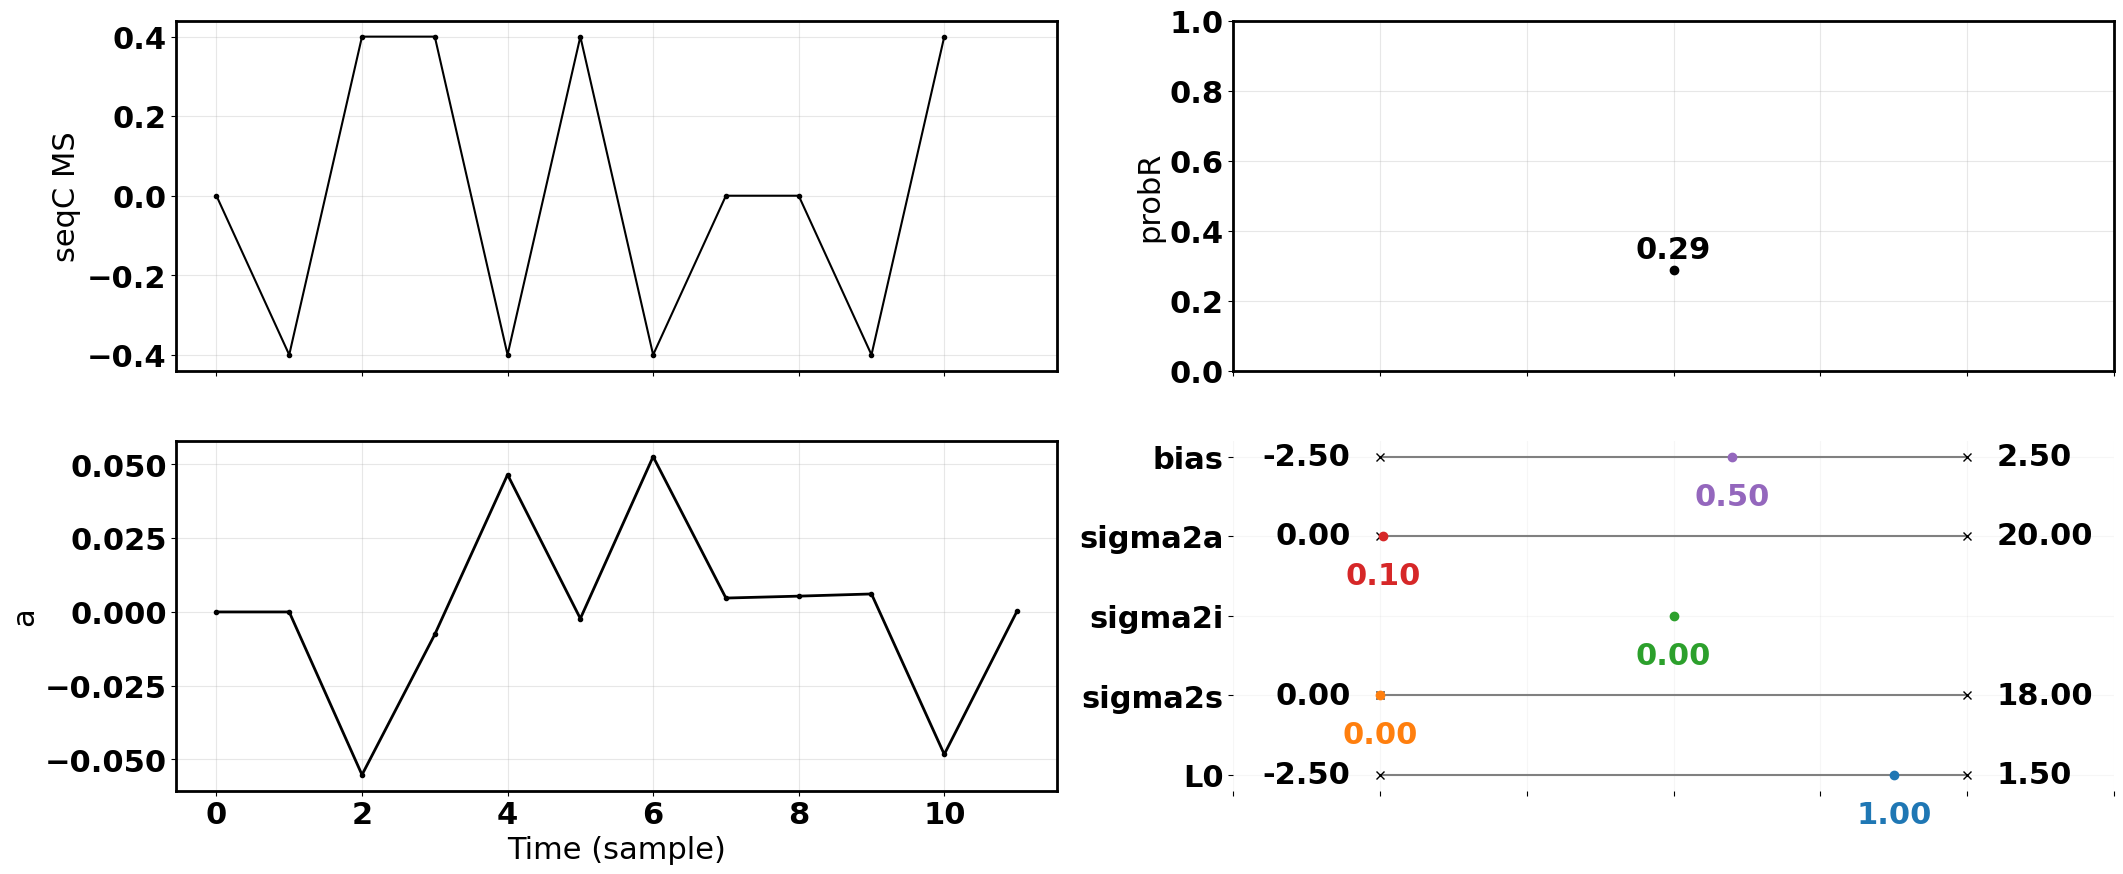

In [59]:
fig, axs = plt.subplots(2,2, sharex='col', figsize=(25, 10))

def update(frame):
    print(frame)
    ax = axs[0,0]
    ax.clear()
    ax.plot(seqC[0], '.-k')
    ax.grid(alpha=0.3)
    ax.set_ylabel('seqC MS')
    
    
    ax = axs[0,1]
    ax.clear()
    ax.plot(np.zeros(len(probRs_collection[:frame])), probRs_collection[:frame], '.', color='grey')
    ax.plot(0, probRs_collection[frame], 'o', color='k')
    if probR<0.5:
        ax.text(0, probRs_collection[frame]+0.1, f'{probRs_collection[frame]:.2f}', ha='center', va='top', color='k')
    else:
        ax.text(0, probRs_collection[frame]-0.1, f'{probRs_collection[frame]:.2f}', ha='center', va='bottom', color='k')
    ax.set_xlim(-1,1)
    ax.set_ylim(0,1)
    ax.grid(alpha=0.3)
    ax.set_ylabel('probR')
    
    # plot a mean trace
    ax = axs[1,0]
    ax.clear()
    ax = model.plot_a_mean_trace(ax, a_collection[frame], color='k')
    
    # plot parameter values
    ax = axs[1,1]
    ax.clear()
    params = params_collection[frame]
    plot_parameters(ax, params, prior_min, prior_max)
    

ani = animation.FuncAnimation(fig, update, frames=len(params_collection), interval=5)
# ani = animation.FuncAnimation(fig, update, frames=30, interval=5)
animation_location = Path('../../figures/prior_tuning')
ani.save(animation_location/video_name, fps=5)  

## todo check the distribution of random sampled prior
## todo check the computed probR
## todo check the values of a[-1]

0 0
1 0
0 1
2 0
1 1
1 1
1 2
0 3
1 0
0 1
0 0
1 0


[(1, 1), (2, 1), (1, 3), (1, 1), (1, 1)]

In [20]:
i = 0
if i==0:
    print('fei')

In [23]:
a = None
a